In [17]:

import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import yfinance as yf
import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.13.0
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [18]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = yf.download('028050.KS', start, end)
print(google.head(5))

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open    Volume
Ticker        028050.KS    028050.KS    028050.KS    028050.KS 028050.KS
Date                                                                    
2000-12-01  1851.257324  1851.257324  1792.017090  1847.554810    222800
2000-12-04  1829.042236  1895.687500  1814.232178  1851.257324    196100
2000-12-05  1840.149780  1851.257324  1817.934692  1817.934692    158800
2000-12-06  1843.852173  1910.497432  1843.852173  1873.472288    287600
2000-12-07  1825.339478  1843.852048  1817.934449  1829.041992    147900


<Axes: xlabel='Date'>

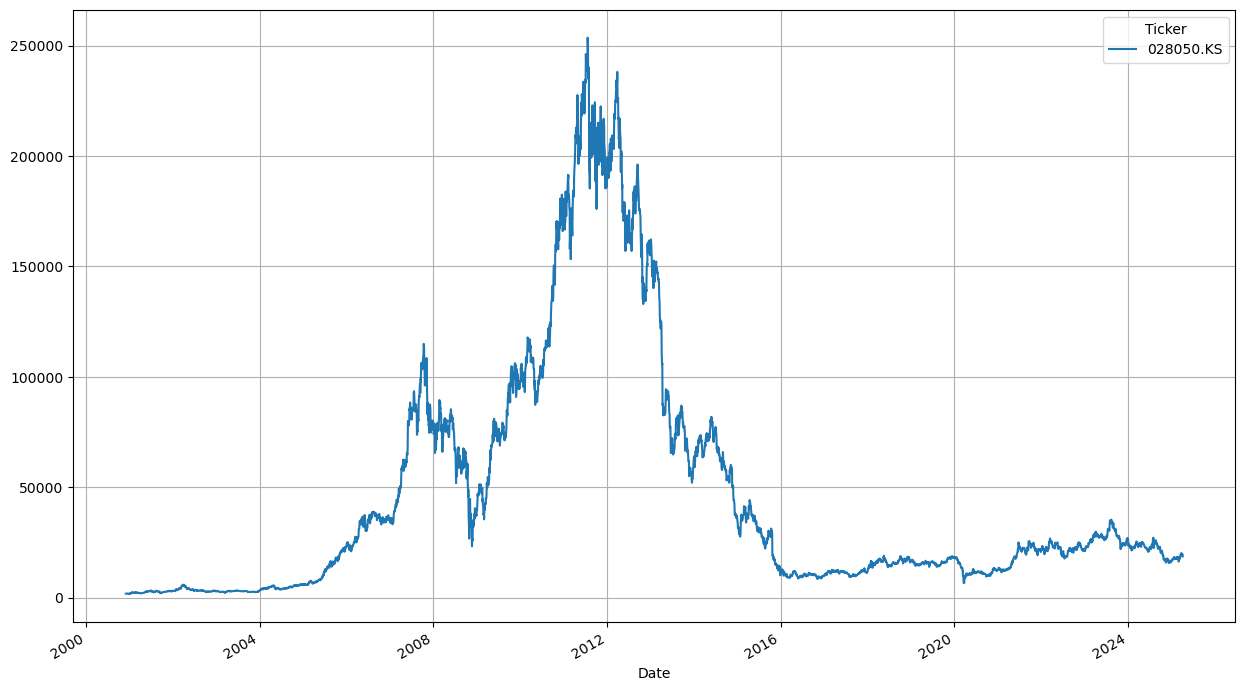

In [19]:
google.Low.plot(grid=True)

<Axes: xlabel='Date'>

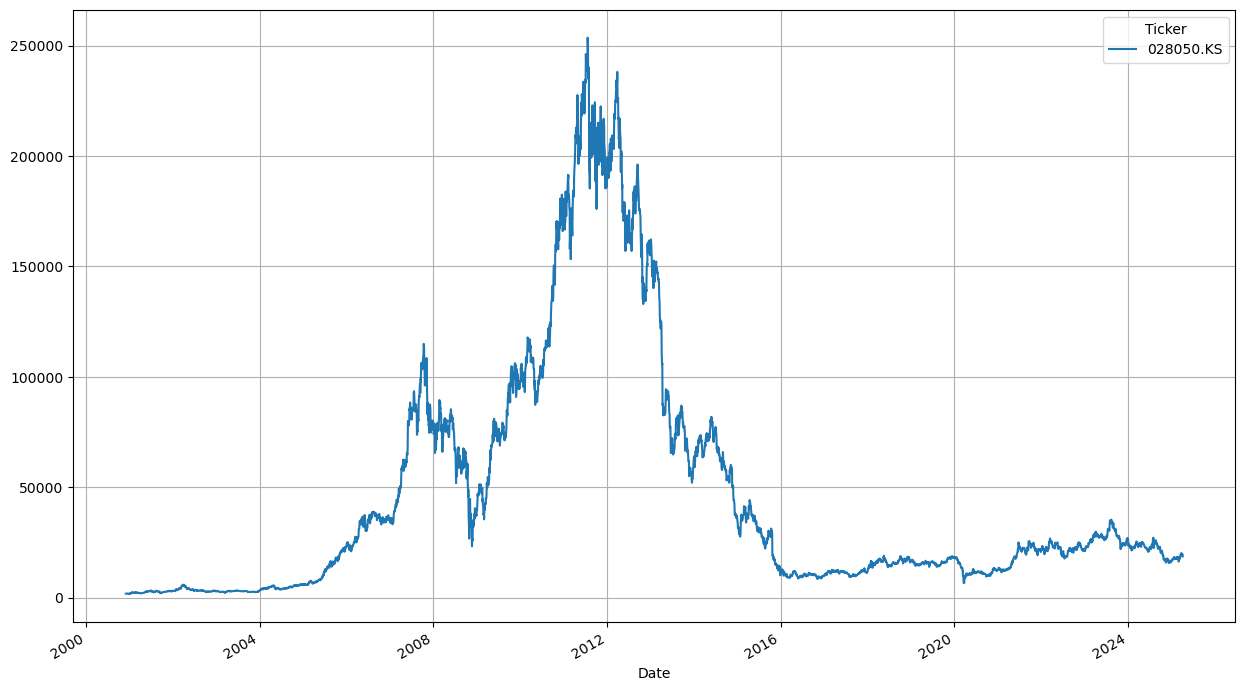

In [20]:
google.Low.plot(grid=True)

In [21]:
google.tail()
print(google.isna().sum())

Price   Ticker   
Close   028050.KS    0
High    028050.KS    0
Low     028050.KS    0
Open    028050.KS    0
Volume  028050.KS    0
dtype: int64


In [23]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = yf.download('028050.KS', start, end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Volume']]
        
        # (log(x+1) - log(x_ref+1)): 기준 시점(x_frames-1) 대비 변화율을 의미.
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames] # 자른 앞쪽 : X
        y = data[self.x_frames:] # 자른 뒤쪽 : y
        
        return X, y
        

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()

        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()

        def init_hidden(self):
            return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                    torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
        def make_regressor(self):
            layers = []
            if self.use_bn:
                layers.append(nn.BatchNorm1d(self.hidden_dim))
            layers
